# Deep Neural Network
## Author: John Hennigan
### This notebook generates and tests a model to predict the following years utilization of mental helath services based on the current years Google Trends data

### Features
####

### Target
####

In [51]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import random



In [52]:
#Custom functions to render graphs

def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

#Custom funtion to add features missing in dataset
def add_previous_year_features(df, feature_cols):
    # Sort the DataFrame by state_id and year
    df = df.sort_values(by=['state_id', 'year'])
    
    # Add the previous year's util rate
    df['prev_util_rate'] = df.groupby('state_id')['util_rate'].shift(1)
    
    # List to store new feature columns
    new_feature_cols = ['prev_util_rate']
    
    # Add the previous year's values for each feature column
    for col in feature_cols:
        new_col = f'prev_{col}'
        df[new_col] = df.groupby('state_id')[col].shift(1)
        new_feature_cols.append(new_col)
    
    return df, new_feature_cols

In [53]:
#read the data, add a tgt column
df = pd.read_csv("../data/aggregated_data_renamed.csv")
df = df.sort_values(by=['state_id', 'year'])

# Add the tgt_util_rate column which is the util_rate for the state at the following year
df['tgt_util_rate'] = df.groupby('state_id')['util_rate'].shift(-1)
df.to_csv("../data/aggregated_data_with_tgt.csv")

Epoch 1/100


C:\Users\johnb\AppData\Local\Temp\ipykernel_31252\793659460.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('state_id').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)
c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0525 - mae: 0.1692 - val_loss: 0.0111 - val_mae: 0.0808
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - mae: 0.1108 - val_loss: 0.0070 - val_mae: 0.0671
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.1015 - val_loss: 0.0061 - val_mae: 0.0629
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - mae: 0.0859 - val_loss: 0.0054 - val_mae: 0.0574
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - mae: 0.0707 - val_loss: 0.0049 - val_mae: 0.0544
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.0738 - val_loss: 0.0050 - val_mae: 0.0544
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - mae: 0.0720 - val_loss: 0.0054 - val_mae: 0.0572
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - mae: 0.0630 - val_loss: 0.0049 - val_mae: 0.0555
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - mae: 0.0737 - val_loss: 0

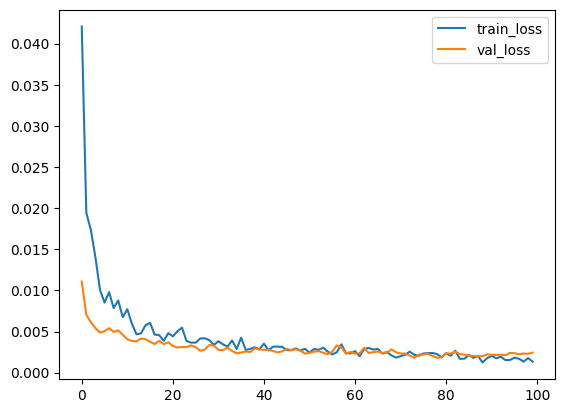

Test R-squared Score: 0.6893237543767026


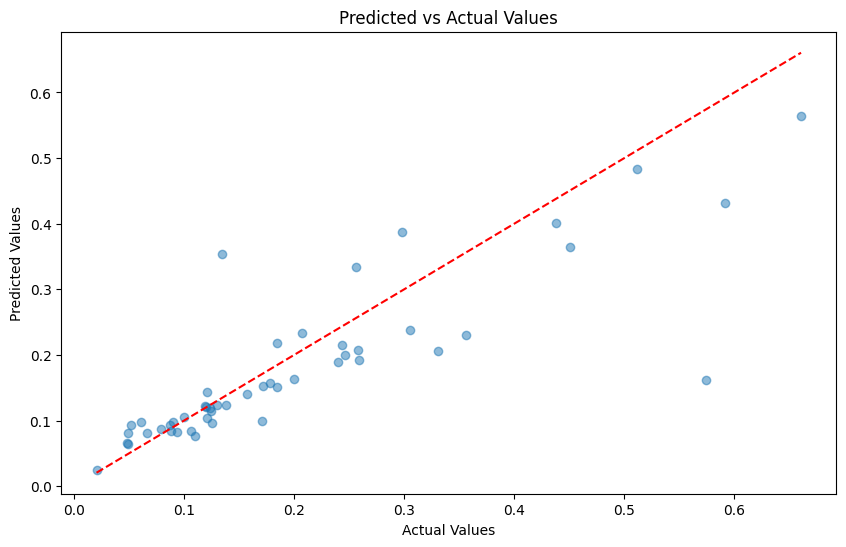

In [54]:
#prep the model and data

#Originally tested with all available features but a lot of 0s are coming from treatment seeking variables
#removing and leaving only the diagnoses for second iteration
#first iteration results: Test R-squared Score: 0.13526324422690883

feature_cols = [
    "max_ADHD", "max_PTSD", "max_anxiety", "max_bipolar", "max_depression",
    # "max_mental hospital", "max_psychiatrists near me", "max_psychologist near me", "max_therapist near me",
    "mean_ADHD", "mean_PTSD", "mean_anxiety", "mean_bipolar", "mean_depression",
    # "mean_mental hospital", "mean_psychiatrists near me", "mean_psychologist near me", "mean_therapist near me",
    "median_ADHD", "median_PTSD", "median_anxiety", "median_bipolar", "median_depression",
    # "median_mental hospital", "median_psychiatrists near me", "median_psychologist near me", "median_therapist near me"
]

df, feature_cols = add_previous_year_features(df, feature_cols)


target_col = "tgt_util_rate"
df = df.groupby('state_id').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)
# Drop rows where `tgt_util_rate` is Empty
df = df.dropna(subset=[target_col])

# Split the data into training and testing sets based on the values from Professors formula
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.14, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Mean Absolute Error: {mae}')

# Make predictions
y_pred = model.predict(X_test)

#plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred)
print(f'Test R-squared Score: {r2}')

plot_predictions_vs_actual(y_test, y_pred.flatten())